In [1]:
#@title import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import numpy as np
import random

# Set seeds for reproducibility
SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Machine Unlearning on a MNIST classifier - BASELINE test

In [2]:
#@title define the neural network

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NN()

In [3]:
#@title loading and preprocessing data

# Define transformations for the training and validation data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

##Setup and Initial Training
To begin, we'll train a neural network to classify the MNIST dataset. This section covers the steps from setting up environment to evaluating the model's accuracy. If you prefer, you can skip this section and use the pre-trained model from the GitHub repository (instructions for downloading are in the next section).

In [19]:
#@title define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#@title train the network

n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f' Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

In [ ]:
#@title evaluate the network

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 94.9%


In [4]:
#@title save the model

joblib.dump(model, "MNIST_Classifier.joblib")

['MNIST_Classifier.joblib']

## Unlearning
da revisionare ancora

https://chatgpt.com/share/0b46d5e8-f041-4de5-8d8b-7e5ba35318db

In [5]:
#@title download the pre-trained model from GitHub (if you skipped the previous section)
!wget -O MNIST_Classifier.joblib 'https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST_Classifier.joblib'
model = joblib.load('MNIST_Classifier.joblib')

--2024-06-15 09:16:11--  https://github.com/mich1803/Yesterday-Machine-Unlearning/raw/main/saved%20models/MNIST_Classifier.joblib
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mich1803/Yesterday-Machine-Unlearning/main/saved%20models/MNIST_Classifier.joblib [following]
--2024-06-15 09:16:11--  https://raw.githubusercontent.com/mich1803/Yesterday-Machine-Unlearning/main/saved%20models/MNIST_Classifier.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440459 (430K) [application/octet-stream]
Saving to: ‘MNIST_Classifier.joblib’

MNIST_Classifier.jo 100%[===================>] 430.14K  --.-KB

In [6]:
final_layer_weights = model.fc3.weight
weights_for_6 = final_layer_weights[6]

In [7]:
# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc3.parameters():
    param.requires_grad = True

# Redefine optimizer for the fine-tuning process
optimizer = optim.SGD(model.fc3.parameters(), lr=0.01)

# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        # Create a modified version of labels where 6 is replaced by 3
        modified_labels = torch.where(labels == 6, 3, labels)
        loss = self.cross_entropy(outputs, modified_labels)
        return loss

criterion = CustomLoss()

# Fine-tune the network
n_epochs = 2
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc = f"epoch: {epoch + 1}. "):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


epoch: 0. : 100%|██████████| 938/938 [00:21<00:00, 44.57it/s]


Fine-tuning Epoch 1, Loss: 0.2339585435066396


epoch: 1. : 100%|██████████| 938/938 [00:19<00:00, 47.88it/s]

Fine-tuning Epoch 2, Loss: 0.1943203726890626


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set after fine-tuning: {100 * correct / total}%')


Accuracy on the test set after fine-tuning: 85.36%


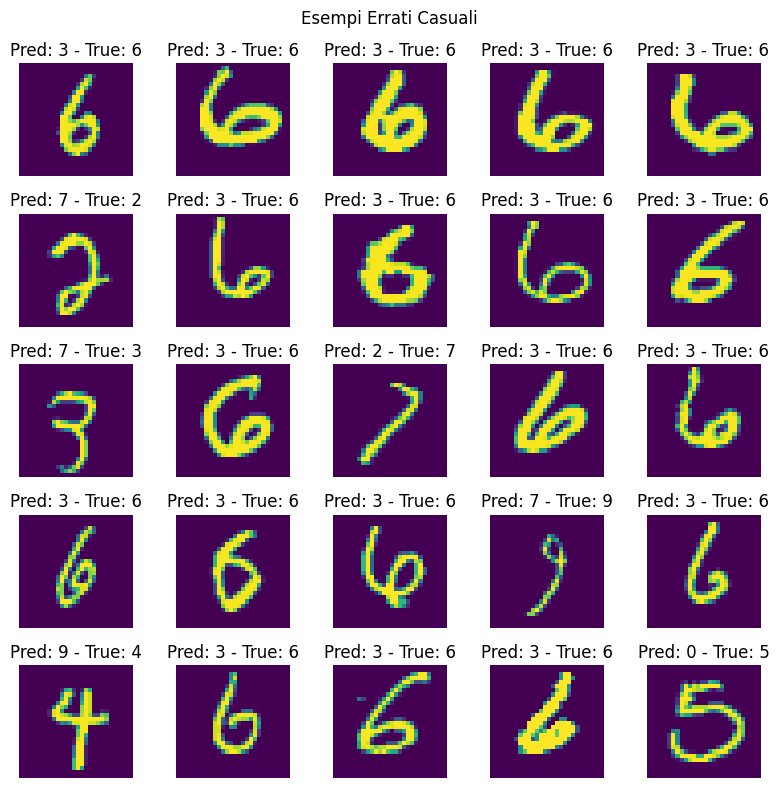

In [11]:
misclassified_images = []
misclassified_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # Trova gli indici degli errori
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(predicted[idx].cpu())
            true_labels.append(labels[idx].cpu())

num_samples = min(25, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), num_samples, replace=False)

# Impostare la griglia 5x5
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Esempi Errati Casuali')

# Iterare sugli indici selezionati per visualizzare le immagini
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = misclassified_images[idx]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'Pred: {misclassified_labels[idx].item()} - True: {true_labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels == 6
        if mask.sum() == 0:
            continue #if there are no 6, skip this batch

        images_6 = images[mask]
        labels_6 = labels[mask]
        outputs = model(images_6)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_6.size(0)
        correct += (predicted == labels_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on immagini with label 6: {accuracy:.2f}%')


Accuracy sulle immagini con label 6: 0.00%


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        mask = labels != 6
        if mask.sum() == 0:
            continue

        images_not_6 = images[mask]
        labels_not_6 = labels[mask]

        outputs = model(images_not_6)
        _, predicted = torch.max(outputs.data, 1)

        total += labels_not_6.size(0)
        correct += (predicted == labels_not_6).sum().item()

accuracy = 100 * correct / total if total > 0 else 0
print(f'Accuracy on images with other labels (not 6): {accuracy:.2f}%')


Accuracy on images with other labels (not 6): 94.40%
